## ML Project: Predicting Car Prices


In [1]:
# Import front end lib
import pandas as pd
import requests
from collections import namedtuple
import re
import numpy as np
import itertools
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

#Building wedgets to make interactive function
import ipywidgets as wg
from ipywidgets import *
from IPython.display import display

#the lib below to make pandas DF shows pretty tabels
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# Run IPython kernal as HTML slidshow
#!jupyter nbconvert  MLProjectCarspricesprediction.ipynb   --to slides --post serve

### Dataset download and preperations process 

In [2]:
## Download the webpage to extract the columns name and dataset dataframe
def download_pars_dataset(url_cols, url_dataset):
    """
    Downloading and parsing columnes /dataset
    Inputs:
    __________________
     - url_cols: str
        URL of columns data
     - url_dataset: str
        URL of dataset
    Outputs:
    __________________
     - columns name with final dataset as dataframe 
    """
    #Downloading and parsing columns
    r_cols = requests.get(url_cols)
    data_text = r_cols.text
    data_text_lines = data_text.splitlines()
    cols = []
    for line in data_text_lines:
        pattern0 = r"\s\d+. ([a-zA-Z]+).*:"
        if re.search(pattern0, line):
            cols.append(line)
    col_nme = [re.split(':?', entry, 3) for entry in cols]

    # Final column names
    pattern1 = r"([a-zA-Z]+)"
    cols_nme = [re.search(pattern1, col[0]).group() for col in col_nme]

    #Downloadung and parsing dataset
    r_dataset = requests.get(url_dataset)
    dataset_text = r_dataset.text.split('\n')
    data_set_cars = [item for item in dataset_text]
    cars_dataset = pd.DataFrame(
        [x.split(",") for x in data_set_cars], columns=cols_nme)
    return cars_dataset

## Téléchargez la page Web pour extraire le nom des colonnes et l'ensemble de données du dataset
def download _pars_ ensemble de données (url _cols, url_ ensemble de données):
    "" "
    Téléchargement et analyse de columnes / dataset
    Contributions:
    ____ ____ ____ ____ __- url_cols: str
        URL des données de colonnes
     - url_dataset: str
        URL de l'ensemble de données
    Les sorties:__ ____ ____ ____ ____
     - nom des colonnes avec l'ensemble de données final en tant que données
    "" "
    #Télécharger et analyser les colonnes
    r _cols = requests.get (url_ cols)
    données _text = r_ cols.text
    data _text_ lignes = données _text.splitlines ()
    cols = []
    pour les lignes de données_ text _:
        pattern0 = r "\ s \ d +. ([a-zA-Z] +). *:"
        si re.search (motif0, ligne):
            cols.append (ligne)
    col_ nme = [re.split (':?', entry, 3) pour l'entrée dans cols]

    # Noms de colonnes finaux
    pattern1 = r "([a-zA-Z] +)"
    cols _nme = [re.search (pattern1, col [0]). group () pour col dans col_ nme]

    #Downloadung et l'analyse de données
    r _dataset = requests.get (url_ ensemble de données)
    dataset _text = r_ dataset.text.split ('\ n')
    data _set_ cars = [élément de l'élément dans le jeu de données _texte]
    cars_ dataset = pd.DataFrame (
        [x.split (",") pour x dans les données _set_ cars], columns = cols _nme)
    retour des voitures_ ensemble de données

In [3]:
# Setting up a numeric features dataframe
## Parsing "imports-85.names" to find the column names for the dataset
url_cols = "http://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.names"
url_dataset = "https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data"

# Download the dataset and convert it to dataframe
cars_dataset_numeric_features = download_pars_dataset(url_cols=url_cols, url_dataset=url_dataset)
cars_dataset_numeric_features = cars_dataset_numeric_features.apply(lambda x: pd.to_numeric(x,errors='coerce'))    

# Decide which cols. have certain Nan values (e.g. > 100) to be reduced from the original dataframet
new = cars_dataset_numeric_features.isnull().apply(sum, axis=0) > 100 
cars_new_numeric_dataset = cars_dataset_numeric_features.drop(cars_dataset_numeric_features.loc[:,new], axis=1)
cars_new_numeric_dataset.head()


/Users/omar/anaconda3/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


,symboling,normalized,wheel,length,width,height,curb,bore,stroke,compression,horsepower,peak,city,highway,price
0,3.0,NaN,88.6,168.8,64.1,48.8,2548.0,3.47,2.68,9.0,111.0,5000.0,21.0,27.0,13495.0
1,3.0,NaN,88.6,168.8,64.1,48.8,2548.0,3.47,2.68,9.0,111.0,5000.0,21.0,27.0,16500.0
2,1.0,NaN,94.5,171.2,65.5,52.4,2823.0,2.68,3.47,9.0,154.0,5000.0,19.0,26.0,16500.0
3,2.0,164.0,99.8,176.6,66.2,54.3,2337.0,3.19,3.40,10.0,102.0,5500.0,24.0,30.0,13950.0
4,2.0,164.0,99.4,176.6,66.4,54.3,2824.0,3.19,3.40,8.0,115.0,5500.0,18.0,22.0,17450.0


In [4]:
# Detremine missing values in cols with max number of NaN among rows
missing_values_cars_df = cars_new_numeric_dataset.isnull().apply(sum, axis=1)

# max number of NaN presnets in the data across the cols
max_num_nan_rows = missing_values_cars_df.value_counts() 

# max number of NaN among rows is 15
max_num_nan_rows.index 

Int64Index([0, 1, 2, 3, 15], dtype='int64')

In [5]:
# Drop row across set of cols that have all NaN values 
row_max_nan = missing_values_cars_df[missing_values_cars_df.apply(
    lambda x: x == max(max_num_nan_rows.index))]
cars_df_after_removing_nan_max = cars_new_numeric_dataset.drop(list(row_max_nan.index))

# Impute missing values "NaN" using mean values across cols
## Note: there is a class called "imputer" within "from sklearn.preprocessing 
##import Imputer" which can handel missing values "other than NaN"
mean_vla_cols = cars_df_after_removing_nan_max.apply(lambda x: np.mean(x), axis=0)
cars_df_with_mean = cars_df_after_removing_nan_max.replace(np.nan, mean_vla_cols)
cars_df_with_mean.head()

## Imputing missing values: Simulating distribution method
#mean_df_nan = cars_df_after_removing_nan_max['price'].mean()
#std_df_nan = cars_df_after_removing_nan_max['price'].std()
#cars_new_sim_df = pd.DataFrame(np.random.normal(mean_df_nan, std_df_nan, 
#len(cars_df_after_removing_nan_max['price'])))
#nan_label = cars_new_sim_df[cars_df_after_removing_nan_max['price'].isnull()]
#cars_df_after_removing_nan_max['price'].loc[list(nan_label[0].index)]=nan_label[0]
#cars_df_after_removing_nan_max['price'].head(10)
#nan_label


,symboling,normalized,wheel,length,width,height,curb,bore,stroke,compression,horsepower,peak,city,highway,price
0,3.0,122.0,88.6,168.8,64.1,48.8,2548.0,3.47,2.68,9.0,111.0,5000.0,21.0,27.0,13495.0
1,3.0,122.0,88.6,168.8,64.1,48.8,2548.0,3.47,2.68,9.0,111.0,5000.0,21.0,27.0,16500.0
2,1.0,122.0,94.5,171.2,65.5,52.4,2823.0,2.68,3.47,9.0,154.0,5000.0,19.0,26.0,16500.0
3,2.0,164.0,99.8,176.6,66.2,54.3,2337.0,3.19,3.40,10.0,102.0,5500.0,24.0,30.0,13950.0
4,2.0,164.0,99.4,176.6,66.4,54.3,2824.0,3.19,3.40,8.0,115.0,5500.0,18.0,22.0,17450.0


In [6]:
# Normalize cars dataset
cars_normalized_df = (cars_df_with_mean-cars_df_with_mean.mean()) / (cars_df_with_mean.max() - cars_df_with_mean.min())
cars_normalized_df.head()

,symboling,normalized,wheel,length,width,height,curb,bore,stroke,compression,horsepower,peak,city,highway,price
0,0.433171,0.000000,-0.296110,-0.078347,-0.150650,-0.410407,-0.002935,0.100178,-0.274011,-0.071409,0.028099,-0.051171,-0.117209,-0.098716,0.007146
1,0.433171,0.000000,-0.296110,-0.078347,-0.150650,-0.410407,-0.002935,0.100178,-0.274011,-0.071409,0.028099,-0.051171,-0.117209,-0.098716,0.081745
2,0.033171,0.000000,-0.124099,-0.042526,-0.033984,-0.110407,0.103737,-0.464108,0.102180,-0.071409,0.207266,-0.051171,-0.172764,-0.125032,0.081745
3,0.233171,0.219895,0.030420,0.038071,0.024350,0.047927,-0.084781,-0.099822,0.068846,-0.008909,-0.009401,0.152910,-0.033875,-0.019769,0.018442
4,0.233171,0.219895,0.018758,0.038071,0.041016,0.047927,0.104125,-0.099822,0.068846,-0.133909,0.044766,0.152910,-0.200542,-0.230295,0.105329


### Building univariate k-nearest neighbors models: Predicting car prices

In [7]:
# univariate k-nearest neighbors 

## Building univariate k-nearest neighbors function
def knn_train_test(feature_nme, target_nme, df, perc_fig, n_neigh):
    """
    Univariate KNN model
    Inputs:
    _____________
     - feature_nme: str
         a col. that used as a feature input
     - target_nme: str
         a col. to predict 
     - df: dataframe
         dataframe input
     - perc_fig: float
         a '%' used to set up training/testing samples
     Outputs:
     ____________
     - list of average RMSE for Knn model 
    """
    # Set up training /testing set
    perc_train_test = round(len(df[feature_nme])* perc_fig)
    training_set = df.iloc[:perc_train_test]
    testing_set = df.iloc[perc_train_test:]
    
    # Set up univariate k-nearest neighbors models
    knn = KNeighborsRegressor(n_neighbors = n_neigh, algorithm='brute')
    fit = knn.fit(training_set[feature_nme], training_set[target_nme])
    predicts = knn.predict(testing_set[feature_nme])
    RMSE = np.sqrt(mean_squared_error(testing_set[target_nme], predicts))
    return RMSE

In [8]:
# Applying univariate k-nearest neighbors function to cars 
#datatframe and find the best fit

## Link a float slide widget to univariate Knn model
def knn_model(perc_fig, n_neigh):
    """
    apply knn func "knn_train_test" to find best univariate model
    Inputs:
    _____________
     - perc_fig: float
         a % to use for setting up training/testing data sebsets
     - n_neigh: int
         n_neigh. value to set up Knn model
    Outputs:
    ____________
     - plot of average RMSE for n random iteration/hyperprameter
    """
    ## Applying "knn_train_test" to find best univariate Knn model
    knn_model_rmse = {}
    for col in cars_normalized_df.columns:
        if col != 'price':
            feature_model = knn_train_test([col],['price'], cars_normalized_df, perc_fig, n_neigh)
            knn_model_rmse[col] = feature_model
    ## Plotting RMSE of univariate Knn model
    ax.clear()
    ax.bar(knn_model_rmse.keys(),knn_model_rmse.values())
    frm_color = 'white'
    ax.tick_params(color=frm_color, labelcolor=frm_color)
    for spine in ax.spines.values():
        spine.set_edgecolor(frm_color)
    plt.suptitle('Univariate k-nearest neighbors RMSE', color=frm_color)
    plt.xticks(rotation=40)
    plt.show()
 

<IPython.core.display.Javascript object>


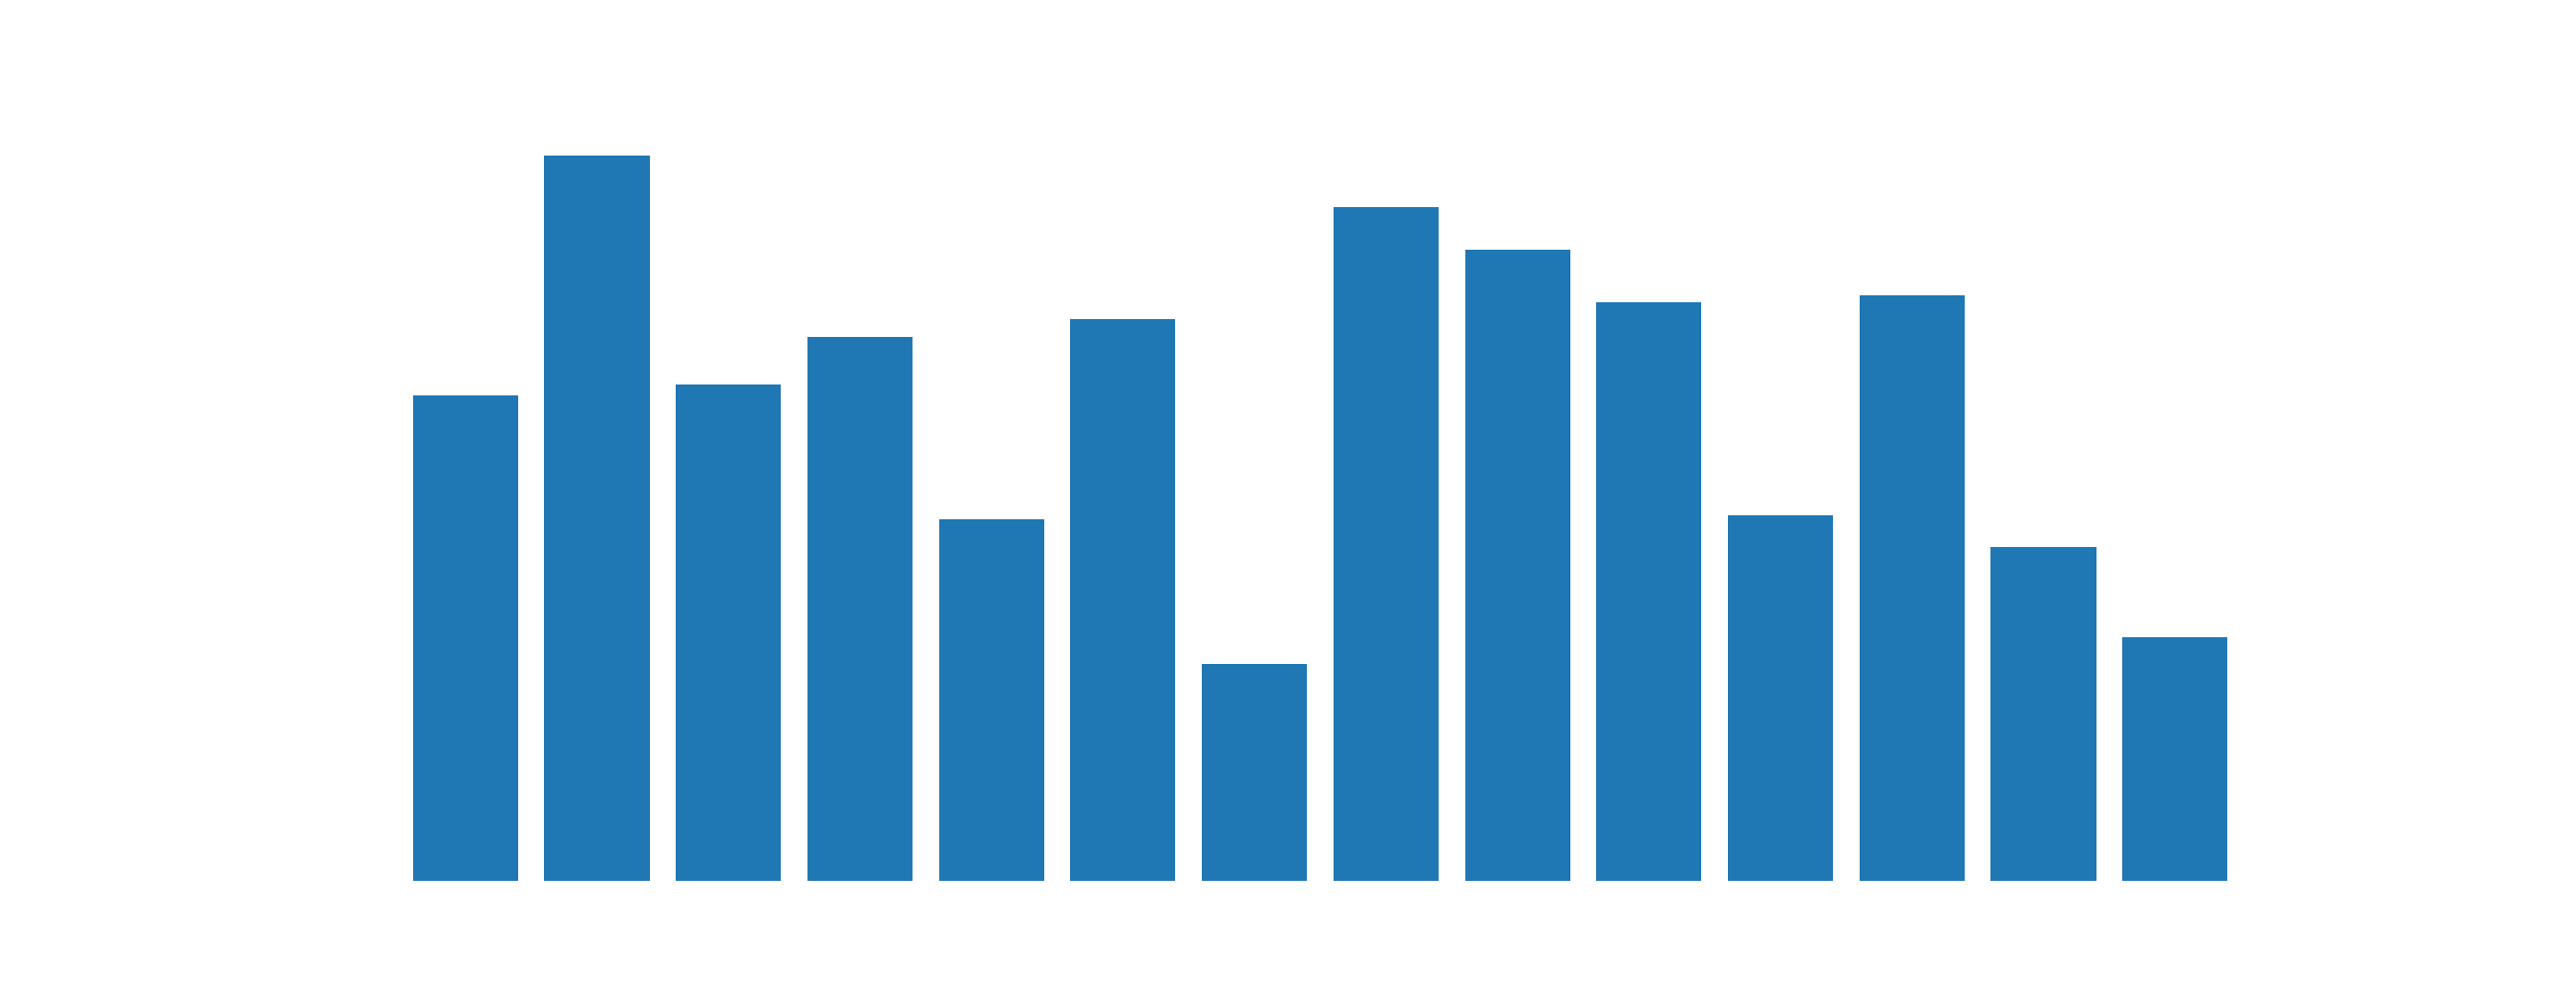

interactive(children=(FloatSlider(value=0.05, description='% of training dataset:', max=1.0, min=0.05, step=0.01), IntSlider(value=2, description='n_neighbors parameter:', max=10, min=2), Output()), _dom_classes=('widget-interact',))

In [10]:
## High-resolution plot outputs for Retina notebooks
%matplotlib nbagg
#%matplotlib inline
%config InlineBackend.figure_format = 'retina' 
fig, ax  = plt.subplots(1, figsize=(13,5))
## manupolate dataframe 
#df.resample('W').sum().plot 

# Set up a widget to manipulate RMSE by changing training/testing percentage of df
perc_training = wg.FloatSlider(min=0.05,max=1,step=.01,description='% of training dataset:')
n_ne = wg.IntSlider(min=2,max=10,step=1,description='n_neighbors parameter:')
wg.interactive(knn_model, perc_fig=perc_training, n_neigh=n_ne)
#knn_model(.8, 5)
#display(perc_training, n_neigh)

### Key take away from the univariate Knn model
 - The univariat Knn model applies one feature each step at a time to predict the "target" car price
 - By changing the widgets sliders, we can view the best univariate Knn model (i.e with lowest RMSE value compared to other univariate Knn models) as follows;
- at 50-50 training/testing with default n_neighbor parameter (k = 5), the best univariate model  is with a "height" independent var, while setting training/testing with default n_neighbor parameter (k = 5) at 80-20, the best univariate model revealed with a "compression" independent var.
- Increasing n_neighbor parameter doesn't countribute to the performance 
- Having build a slide widgets linked to the univariate Knn model gives another perspective of the best univarite Knn model with lowest RMSE testing procedures


### Building multivariate k-nearest neighbors models: Predicting car prices   

In [ ]:
# Multivariate k-nearest neighbors 

## Building Multivariate k-nearest neighbors function
def multi_knn_train_test(df,features_cols, target_col,prec_train, n_neighbor):
    """
    Multivariate KNN model
     - feature_nme: a col. that used as a feature input
     - target_nme: a col. to predict 
     - df: dataframe input
     - perc_fig: a '%' used to set up training/testing samples
    """
    # Set up training /testing set
    #features_cols = [col for idx, col in enumerate(list(df.columns)) if col != target_col]
    perc_train_test = round(len(df[features_cols])* prec_train)
    training_set = df.iloc[:perc_train_test]
    testing_set = df.iloc[perc_train_test:]
    
    # Set up Multivariate k-nearest neighbors models
    knn = KNeighborsRegressor(n_neighbors = n_neighbor, algorithm='brute')
    fit = knn.fit(training_set[features_cols], training_set[target_col])
    predicts = knn.predict(testing_set[features_cols])
    RMSE = np.sqrt(mean_squared_error(testing_set[target_col], predicts))
    #MAE = sum(np.abs(predicts - testing_set[target_nme])) / len(testing_set)
    #RMSE_prop = RMSE/MAE
    #results = {'RMSE':RMSE, 'MAE':MAE, 'RMSE proportion':RMSE_prop}
    return RMSE

## Link a float slide widget to multivariate Knn model
def multi_knn_model(n_neigh, perc_fig, rand_n):
    """
    apply knn func "knn_train_test" to find best multivariate model for 
    each random set of features
    Inputs:
    ________________
       - n_neigh: int
           n_neighbor parameter in Knn func.
       - perc_fig: float
           % of dataframe splitting up training and testing set
       - rand_n: float
           random 'n' number iterations tp run Knn model
   Outputs:
   _________________
       - list of average RMSE
    """
    ## create random, nonrepetitive pairs from a list of columns
    #for iteration in range(rand_n):
        #multi_col_rnd_selection = {idx:np.random.choice(cars_normalized_df.columns, idx, replace=False) for idx, col in enumerate(cars_normalized_df.columns)}
        #multi_rnd_selection_excpt_0_1 = [item for item in multi_col_rnd_selection.values() if len(item) > 1]
    ###################### New set up#######################   
    result_1 = {}
    features_cols_lst = [col for idx, col in enumerate(list(cars_normalized_df.columns)) if col != 'price']
    for idx, col in enumerate(features_cols_lst):
            x = np.random.choice(features_cols_lst, idx, replace=False)
            result_1[idx] = x
    res1 = [item for item in result_1.values() if len(item) > 1]
            
    ## Applying "knn_train_test" to find best multivariate Knn model based on random feature selction 
    ## Iterating thru each multi-col selection 
    RMSE_total = {}
    for i in range(rand_n):
        RMSE_RES = {}
        for idx,pair in enumerate(res1):
            RMSE_RES[len(pair)] = multi_knn_train_test(cars_normalized_df ,pair ,'price',perc_fig ,n_neigh)
        RMSE_total[i] = RMSE_RES
    lst_rmse = []    
    for i_1 in range(len(RMSE_total.keys())):
        x = list(list(RMSE_total.values())[i_1].values())
        lst_rmse.append(x)
    avrg_rmse = [sum(n)/len(n) for n in list(zip(*lst_rmse))]   
    avrg_rmse_plt_df = pd.DataFrame(avrg_rmse, columns=['Avrg RMSE'] ,index=list(list(RMSE_total.values())[0]))
    
    ## Plotting RMSE of multivariate Knn model
    #ax.clear()
    #avrg_rmse_plt_df.plot(kind='bar', title='AVRG RMSE for N random iteration')

    ## Plotting RMSE of multivariate Knn model
    ax.clear()
    ax.bar(avrg_rmse_plt_df.index,list(avrg_rmse_plt_df['Avrg RMSE']))
    frm_color = 'white'
    ax.tick_params(color=frm_color, labelcolor=frm_color)
    for spine in ax.spines.values():
        spine.set_edgecolor(frm_color)
    plt.style.use('seaborn')
    plt.title('Avrg RMSE for Knn model with n random Iteration', color='white')
    plt.show()
    

In [ ]:
## Applying multivariate k-nearest neighbors function to cars datatframe and find the best fit
# Set up a widget to manipulate RMSE by changing training/testing percentage and n_neighbors parameter  of df 
%matplotlib nbagg
#matplotlib inline
%config InlineBackend.figure_format = 'retina' 
fig, ax  = plt.subplots(1, figsize=(15,5))

## Link and apply Knn model to a plain plot
#multi_knn_model(5, 0.8, 100)


## Link and apply slide widgets 
perc_training = wg.FloatSlider(min=0.5,max=1,step=.01,description='% of training dataset:')
n_neigh = wg.IntSlider(min=1,max=10,step=1,description='n_neighbors parameter:')
rand_n = wg.IntSlider(min=1,max=100,step=1,description='n random Knn model iteration:')
wg.interactive(multi_knn_model,n_neigh=n_neigh, perc_fig=perc_training, rand_n=rand_n)

#display(perc_training, n_neigh)

## Building multivariate k-nearest neighbors models: optimizing model parameters

In [ ]:
def multi_knn_model_results(n_neigh, perc_fig, rand_n):
    """
    apply knn func "knn_train_test" to find best multivariate model for 
    each random set of features
    Inputs:
    ________________
       - n_neigh: int
            n_neighbor parameter in Knn func.
       - perc_fig: float
            % of dataframe splitting up training and testing set
       - rand_n: float
            random 'n' number iterations tp run Knn model
    Output:
    _________________
       - list of average of RMSE 
    """
    ## create random, nonrepetitive pairs from a list of columns  
    result_1 = {}
    features_cols_lst = [col for idx, col in enumerate(list(cars_normalized_df.columns)) if col != 'price']
    for idx, col in enumerate(features_cols_lst):
            x = np.random.choice(features_cols_lst, idx, replace=False)
            result_1[idx] = x
    res1 = [item for item in result_1.values() if len(item) > 1]
            
    ## Applying "knn_train_test" to find best multivariate Knn model based on random feature selction 
    ## Iterating thru each multi-col selection 
    RMSE_total = {}
    for i in range(rand_n):
        RMSE_RES = {}
        for idx,pair in enumerate(res1):
            RMSE_RES[len(pair)] = multi_knn_train_test(cars_normalized_df ,pair ,'price',perc_fig ,n_neigh)
        RMSE_total[i] = RMSE_RES
    lst_rmse = []    
    for i_1 in range(len(RMSE_total.keys())):
        x = list(list(RMSE_total.values())[i_1].values())
        lst_rmse.append(x)
    avrg_rmse = [sum(n)/len(n) for n in list(zip(*lst_rmse))]   
    avrg_rmse_plt_df = pd.DataFrame(avrg_rmse,columns=['Avrg RMSE'] ,index=list(list(RMSE_total.values())[0]))
    return avrg_rmse_plt_df


In [ ]:
# optimazing "multi_knn_model_results" parametrs
# 1. n_neighbor parameter
%time
optimizing_k_niegh_para = list(
    itertools.chain(
        *[np.mean(multi_knn_model_results(iter_1,0.75,10)) for iter_1 in range(2, 60)]
    )
)
# the range been selcted randomly to be betw(2,125) it can be chnaged !

In [ ]:
# 2.trainin / testing datset set up 
%time
## Find the optimum point where Avrg-RMSE is the lowest
optimizing_train_test_para = list(
    itertools.chain(
        *[np.mean(multi_knn_model_results(5,iter_2,10)) for iter_2 in [((x /.1) / 100) for x in range(1, 10)]]   
    )
)

In [ ]:
# 3. Find the best Multi Knn model based on optmizing the prev. parameters
%time

optimizing_multi_knn_model = list(
    itertools.chain(
        *[np.mean(multi_knn_model_results(45,.8,iter_3)) for iter_3 in range(1, 50)]
    )
)        

In [ ]:
#%matplotlib nbagg
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 
## Build a visualizations for parametrs
fig, axs = plt.subplots(3, figsize=(15,12))

##setting up the plot frame / title text color
frm_color = 'white'
for ax in axs:
    ax.tick_params(color=frm_color, labelcolor=frm_color)
    for spine in ax.spines.values():
        spine.set_edgecolor(frm_color)
        
## plotting up the results
axs[0].plot(optimizing_k_niegh_para)
axs[0].set_title('n_neighbor parameter - Hyperprameter', color=frm_color)
axs[0].set_ylabel('AVRG RMSE', color=frm_color)


axs[1].plot(optimizing_train_test_para)
axs[1].set_title('trainin / testing datset set up ', color=frm_color)
axs[1].set_ylabel('AVRG RMSE', color=frm_color)
axs[1].set_xlim(xmin=0.1)

axs[2].plot(optimizing_multi_knn_model)
axs[2].set_title('Best Knn model',  color=frm_color)
axs[2].set_ylabel('AVRG RMSE', color=frm_color)

### Key take away from the multivariate Knn model
    - 

## Appendix: Add some functionality 

In [ ]:

def search_text_google(text_str, lng, stop_val):
    """
    Simple google search func 
    """
    for url in search(text_str, tld='com', lang=lng, stop=stop_val):
        print(url)

def download_data(url):
    """
    Helps retrieving wheather applying request is sucsseful or not with 
    showing results 
    """
    Response = namedtuple('Response', ['data', 'error'])
    try:
        r = requests.get(url)
    except Exception as e:
        return Response(data = None , error = e)
    if r.status_code == 200:
        return Response(data=r, error=None)
    else:
        return Response(data=None, error=r.reason)

def gen_all_features_combinations(df, target_col):
    """
    This func generates (2^n -1) possible combinations for the features list (itertools should be imported)
    within df excluding target col.
      - df: defined dataframe 
      - target_col: the target column to be excluded from the main dataframe 
    """
    x =[col for idx, col in enumerate(list(df.columns)) if col != target_col]
    features_lst = [list(subset) for l in range(0, len(x)+1) for subset in itertools.combinations(x, l)]
    return features_lst

#(2^n)n >> combination with repetition (itertools.permutations)
#2^n >> combination without repetition (itertools.combinations)

##  Multivariate Knn k-fold cross validation 

In [ ]:
# Setting up k-fold for the dataset 
## Classify dataframe to 'i'th k-fold of training and testing seubset
def set_Kfold(kfold_df, k_val):
    """
    generating k-fold to prepare training /testing data subsets
    Inputs:
    _______________
     - df: dataframe 
         input dataframe
     - k_val: int
         int value to define a k-fold to seubset dataframe 
     Output:
     ______________
     - generates dataframe with "fold" column representing k-fold for training/testing subset
    """
    kfold_df['fold'] = 1
    start = int(len(kfold_df)/k_val)
    rng_vls = [int(x) for x in np.linspace(start=start, stop=len(kfold_df), num=k_val)]
    for idx, val in enumerate(rng_vls):
        kfold_df['fold'][rng_vls[idx]-start: val] = idx+1
    return kfold_df 


In [ ]:
## Apply multi Knn model and validating with k-fold methodology
def train_and_validate_kFold(df, Kfold_num, n_neigh, feature_cols, target_cols):
    """
    Multi Knn model with k-fold validation methodology
    Inputs:
    _______________
     - df: dataframe 
         input dataframe
     - kfold_num: int
         int value to define a k-fold to seubset dataframe 
     Output:
     ______________
     - generates dataframe with "fold" column representing k-fold for training/testing subset
    """
    new_kFold_df = set_Kfold(df, Kfold_num)
    fold_ids = list(set(new_kFold_df['fold']))
    rmse = []
    for i in fold_ids:
        training_set = new_kFold_df[new_kFold_df['fold']!=i]
        testing_set =  new_kFold_df[new_kFold_df['fold']==i]

        knn = KNeighborsRegressor(n_neighbors = n_neigh)
        fits = knn.fit(training_set[feature_cols], training_set[target_cols])
        predicts = knn.predict(testing_set[feature_cols])
        iteration_i_rmse = (mean_squared_error(testing_set[target_cols], predicts))**.5
        rmse.append(iteration_i_rmse)
    return rmse

In [ ]:
## Apply multivariate Knn using cros k-fold methodology
def multi_knn_model_kfold(n_neigh, Kfold_num, rand_n):
    """
    apply knn func "knn_train_test" to find best multivariate model for 
    each random set of features
    Inputs:
    ________________
       - n_neigh: int
           n_neighbor parameter in Knn func.
       - perc_fig: float
           % of dataframe splitting up training and testing set
       - rand_n: float
           random 'n' number iterations tp run Knn model
   Outputs:
   _________________
       - list of average RMSE
    """
    ## create random, nonrepetitive pairs from a list of columns
    #for iteration in range(rand_n):
        #multi_col_rnd_selection = {idx:np.random.choice(cars_normalized_df.columns, idx, replace=False) for idx, col in enumerate(cars_normalized_df.columns)}
        #multi_rnd_selection_excpt_0_1 = [item for item in multi_col_rnd_selection.values() if len(item) > 1]
    ###################### New set up#######################   
    result_1 = {}
    features_cols_lst = [col for idx, col in enumerate(list(cars_normalized_df.columns)) if col != 'price']
    for idx, col in enumerate(features_cols_lst):
            x = np.random.choice(features_cols_lst, idx, replace=False)
            result_1[idx] = x
    res1 = [item for item in result_1.values() if len(item) > 1]
            
    ## Applying "knn_train_test" to find best multivariate Knn model based on random feature selction 
    ## Iterating thru each multi-col selection 
    RMSE_total = {}
    for i in range(rand_n):
        RMSE_RES = {}
        for idx,pair in enumerate(res1):
            Kfold_rmse = train_and_validate_kFold(cars_normalized_df, Kfold_num, n_neigh, pair,'price')
            RMSE_RES[len(pair)] = np.mean(Kfold_rmse)
                                    #multi_knn_train_test(cars_normalized_df ,pair ,'price',perc_fig ,n_neigh)
        RMSE_total[i] = RMSE_RES
    lst_rmse = []    
    for i_1 in range(len(RMSE_total.keys())):
        x = list(list(RMSE_total.values())[i_1].values())
        lst_rmse.append(x)
    avrg_rmse = [sum(n)/len(n) for n in list(zip(*lst_rmse))]   
    avrg_rmse_plt_df = pd.DataFrame(avrg_rmse, columns=['Avrg RMSE'] ,index=list(list(RMSE_total.values())[0]))
    
    return avrg_rmse_plt_df


In [ ]:
# Knn model interactivity 
def Kfold_iter(n_neigh, min_rng, max_rng, n_rnd):
    """
    Apply multi_knn_model_kfold function to iterate thru a range of different kfolds
    Imputs:
    ____________
     - n_neigh: int
         n_neighbor parameter for Knn model
     - min_rng: int
         min value of a range 
     - max_rng: int
         max value of a range 
     - min_rng: int
         n range for random iterations
    """
    avrg_rmse_kfolg = []
    for i in range(min_rng, max_rng):
        d = multi_knn_model_kfold(n_neigh, i, n_rnd)
        avrg_rmse_kfolg.append(d['Avrg RMSE'].mean())
        
    #Set up the plot figures and style
    ax.clear()
    ax.bar([(idx+1) for idx, val in enumerate(avrg_rmse_kfolg)], avrg_rmse_kfolg)
    frm_color = 'white'
    ax.tick_params(color=frm_color, labelcolor=frm_color)
    for spine in ax.spines.values():
        spine.set_edgecolor(frm_color)
    plt.style.use('seaborn')
    plt.title('Multi Knn model with Kfold performance / Avrg-RMSE', color='white')
    plt.show()

In [ ]:
## Apply Multivariate Knn with kfold methodology
fig, ax = plt.subplots(1, figsize=(12,5))
Kfold_iter(10, 2, 11, 2)
    